In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import random
from math import sin, cos, sqrt, atan2, radians
from ease_grid import EASE2_grid
grid_size = 36000
egrid = EASE2_grid(grid_size)
import time
from impacts import distance, IMPAaCS

In [2]:
ensembles = list(range(0,50))


In [3]:
sio2_dict = {ensemble:{} for ensemble in ensembles}
n_impact_dict = {}
for ensemble in ensembles:
    for layer in range(12):
        with open("./sio2_percent_tables/march2022_5/ensemble_{:d}_{:d}.csv".format(ensemble, layer), "r")as f:
            sio2_dict[ensemble][layer] = pd.read_csv(f).fillna(0)
    with open("./impact_probabilities_export_march2022_5/ensemble_{:d}.csv".format(ensemble), "r")as f:
        n_impact_dict[ensemble] = pd.read_csv(f).fillna(0)

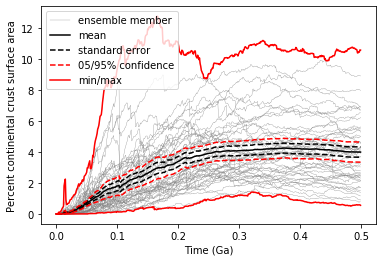

In [4]:
n_layers=1
crust_dict = {}
for ensemble in ensembles:
    for layer in range(n_layers):
        
        percent_bins=[]
        for p in range(58,101):
            if str(p) in list(sio2_dict[ensemble][layer].columns.values):
                percent_bins.append(str(p))
                
        df = sio2_dict[ensemble][layer].loc[:,percent_bins].sum(axis=1)

        if layer == 0:
            crust_dict[ensemble] = df.values
        else:
            crust_dict[ensemble] += df.values
            
    if ensemble == 0:
        plt.plot(df.index.values/1000, df.values, lw=0.3, c='grey', label='ensemble member')
    else:
        plt.plot(df.index.values/1000, df.values, lw=0.3, c='grey')
            
    crust_df = pd.DataFrame(crust_dict, index=df.index.values)
    
    crust_mean = crust_df.mean(axis=1)

crust_df['mean'] = crust_df.mean(axis=1)
crust_df['min'] = crust_df.min(axis=1)
crust_df['max'] = crust_df.max(axis=1)
crust_df['stdev'] = crust_df.std(axis=1)
standard_error = crust_df['stdev']/np.sqrt(len(ensembles))
crust_df['e05'] = crust_df['mean'] - standard_error
crust_df['e95'] = crust_df['mean'] + standard_error
crust_df['c95'] = crust_df['mean'] + standard_error * 1.96
crust_df['c05'] = crust_df['mean'] - standard_error * 1.96

plt.plot(df.index.values/1000, crust_df['mean'], c='k', label='mean')
plt.plot(df.index.values/1000, crust_df['e05'], '--', c='k', label='standard error')
plt.plot(df.index.values/1000, crust_df['e95'], '--', c='k')
plt.plot(df.index.values/1000, crust_df['c05'].clip(lower=0), '--', c='r', label='05/95% confidence')
plt.plot(df.index.values/1000, crust_df['c95'], '--', c='r')
plt.plot(df.index.values/1000, crust_df['min'].clip(lower=0), c='r', label='min/max')
plt.plot(df.index.values/1000, crust_df['max'], c='r')
plt.xlabel("Time (Ga)")
plt.ylabel("Percent continental crust surface area")
#plt.ylim([0,20])
plt.legend()
# plt.savefig('./figs/paper_figs/relative_percent_crust_over_time_bound.pdf', dpi=600)
# plt.savefig('./figs/paper_figs/relative_percent_crust_over_time_bound.png', dpi=600)
plt.show()
plt.close()

In [5]:
final_values = {summary_characteristic:[] for summary_characteristic in ['mean', 'min', 'max',
                                                                         'standard_error', 'CI95']}
for i in range(3,len(ensembles)+1):
    crust_dict = {}
    for ensemble in ensembles[:i]:
        percent_bins=[]
        for p in range(60,100):
            if str(p) in list(sio2_dict[ensemble][0].columns.values):
                percent_bins.append(str(p))
        df = 100* sio2_dict[ensemble][0].loc[:,percent_bins].sum(axis=1) / 40
        crust_dict[ensemble] = df.values
    crust_df = pd.DataFrame(crust_dict, index=df.index.values)
    crust_mean = crust_df.mean(axis=1)
    crust_df['mean'] = crust_df.mean(axis=1)
    crust_df['min'] = crust_df.min(axis=1)
    crust_df['max'] = crust_df.max(axis=1)
    crust_df['stdev'] = crust_df.std(axis=1)
    standard_error = crust_df['stdev']/np.sqrt(len(ensembles))
    crust_df['e05'] = crust_df['mean'] - standard_error
    crust_df['e95'] = crust_df['mean'] + standard_error
    crust_df['c95'] = crust_df['mean'] + standard_error * 1.96
    crust_df['c05'] = crust_df['mean'] - standard_error * 1.96
    final_values['mean'].append(crust_df['mean'][499])
    final_values['min'].append(crust_df['min'][499])
    final_values['max'].append(crust_df['max'][499])
    final_values['standard_error'].append(standard_error[499])
    final_values['CI95'].append(standard_error[499] * 1.96)

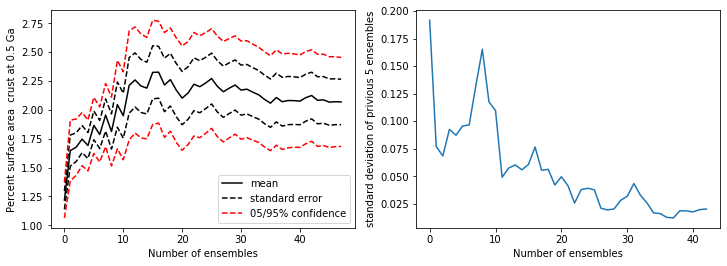

In [6]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)    
ax.plot(final_values['mean'], c='k', label='mean')
ax.plot(np.array(final_values['mean'])+np.array(final_values['standard_error']), 
         '--', c='k', label='standard error')
ax.plot(np.array(final_values['mean'])-np.array(final_values['standard_error']),'--', c='k', )
ax.plot(np.array(final_values['mean'])+np.array(final_values['CI95']), 
         '--', c='r', label='05/95% confidence')
ax.plot(np.array(final_values['mean'])-np.array(final_values['CI95']),'--', c='r', )
ax.set_xlabel("Number of ensembles")
ax.set_ylabel("Percent surface area  crust at 0.5 Ga")
plt.legend()

std_last_5_ens = []
for i in range(5,len(final_values['mean'])):
    std_last_5_ens.append(np.std(final_values['mean'][i-5:i]))
ax = fig.add_subplot(1, 2, 2)
ax.plot(std_last_5_ens)
ax.set_xlabel("Number of ensembles")
ax.set_ylabel("standard deviation of privious 5 ensembles")
# plt.savefig('./figs/paper_figs/ensemble_convergence_bound.pdf', dpi=600)
# plt.savefig('./figs/paper_figs/ensemble_convergence_bound.png', dpi=600)
plt.show()
plt.close()

In [7]:
total_impact_dict = {}
total_impact_dict['low'] = n_impact_dict[ensemble].low
total_impact_dict['high'] = n_impact_dict[ensemble].high
for ensemble in ensembles:
    total_impact_dict[ensemble] = n_impact_dict[ensemble].total

In [8]:
n_x = n_impact_dict[1]['Unnamed: 0'].values.shape[0]
bin_min = [int(n_impact_dict[1]['Unnamed: 0'].values[i].split("-")[0]) for i in range(n_x)]

In [9]:
bin_len = [j-i for i, j in zip(bin_min[:-1], bin_min[1:])]

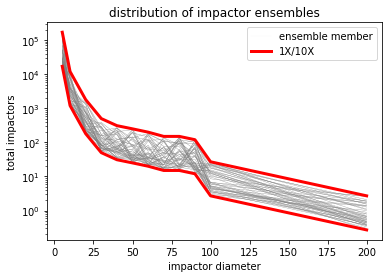

In [10]:
for ensemble in ensembles:
    yvals = [total_impact_dict[ensemble][i]/bin_len[i] for i in range(len(bin_len))]
    if ensemble == 0:
        n_x = n_impact_dict[1]['Unnamed: 0'].values.shape[0]
        xvals = [int(n_impact_dict[1]['Unnamed: 0'].values[i].split("-")[0]) for i in range(n_x)]
        plt.plot(xvals[:-1],yvals, lw=0.03, label="ensemble member", c='grey')
    else:
        plt.plot(xvals[:-1],yvals, lw=0.3, c='grey')
yvals = [total_impact_dict['low'][i]/bin_len[i] for i in range(len(bin_len))]
plt.plot(xvals[:-1], yvals, c='r', lw=3, label='1X/10X')
yvals = [total_impact_dict['high'][i]/bin_len[i] for i in range(len(bin_len))]
plt.plot(xvals[:-1], yvals, c='r', lw=3)
plt.ylabel('total impactors')
plt.yscale('log')
plt.xlabel("impactor diameter")
plt.title("distribution of impactor ensembles")
plt.legend()
# plt.savefig('./figs/paper_figs/total_impacts_bound.pdf', dpi=600)
# plt.savefig('./figs/paper_figs/total_impacts_bound.png', dpi=600)
plt.show()
plt.close()

In [11]:
max_sio2_list={layer:{} for layer in range(12)}
for layer in range(11):
    for ensemble in ensembles:
        max_sio2_list[layer][ensemble]=[]
        for irow in sio2_dict[ensemble][layer].index.values:
            max_sio2_percent=0
            for icol in sio2_dict[ensemble][layer].columns.values[1:]:
                if sio2_dict[ensemble][layer].loc[irow,icol] > 0:
                    if int(icol) > max_sio2_percent:
                        max_sio2_percent = int(icol)
            max_sio2_list[layer][ensemble].append(max_sio2_percent)

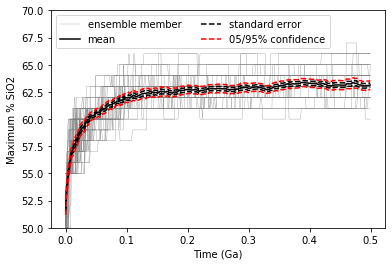

In [12]:
max_sio2_df          = pd.DataFrame(max_sio2_list[0])
max_sio2_df['mean']  = max_sio2_df.mean(axis=1)
max_sio2_df['min']   = max_sio2_df.min(axis=1)
max_sio2_df['max']   = max_sio2_df.max(axis=1)
max_sio2_df['stdev'] = max_sio2_df.std(axis=1)
standard_error       = max_sio2_df['stdev']/np.sqrt(len(ensembles))
max_sio2_df['e05']   = max_sio2_df['mean'] - standard_error
max_sio2_df['e95']   = max_sio2_df['mean'] + standard_error
max_sio2_df['c95']   = max_sio2_df['mean'] + standard_error * 1.96
max_sio2_df['c05']   = max_sio2_df['mean'] - standard_error * 1.96
for ensemble in ensembles:
    if ensemble == 0:
        plt.plot(max_sio2_df.index.values/1000, max_sio2_list[0][ensemble], 
                 lw=0.3, label="ensemble member", c='grey')        
    else:
        plt.plot(max_sio2_df.index.values/1000, max_sio2_list[0][ensemble], lw=0.3, c='grey')

plt.plot(max_sio2_df.index.values/1000, max_sio2_df['mean'], c='k', label='mean')
plt.plot(max_sio2_df.index.values/1000, max_sio2_df['e05'], '--', c='k', label='standard error')
plt.plot(max_sio2_df.index.values/1000, max_sio2_df['e95'], '--', c='k')
plt.plot(max_sio2_df.index.values/1000, max_sio2_df['c05'].clip(lower=0), '--', c='r', label='05/95% confidence')
plt.plot(max_sio2_df.index.values/1000, max_sio2_df['c95'], '--', c='r')
# plt.plot(max_sio2_df.index.values/1000, max_sio2_df['min'].clip(lower=0), c='r', label='min/max')
# plt.plot(max_sio2_df.index.values/1000, max_sio2_df['max'], c='r')
plt.xlabel("Time (Ga)")
plt.ylabel("Maximum % SiO2")
plt.ylim([50,70])
plt.legend(ncol=2)
# plt.savefig('./figs/paper_figs/max_sio2_bound.pdf', dpi=600)
# plt.savefig('./figs/paper_figs/max_sio2_bound.png', dpi=600)
plt.show()
plt.close()

In [13]:
max_sio2_df

,0,1,2,3,4,5,6,7,8,9,...,48,49,mean,min,max,stdev,e05,e95,c95,c05
0,50,50,55,50,50,50,55,55,50,50,...,50,50,51.88,50.0,56.0,2.456131,51.532651,52.227349,52.560805,51.199195
1,55,54,55,50,55,50,55,55,50,50,...,50,55,53.20,50.0,57.0,2.459961,52.852109,53.547891,53.881866,52.518134
2,55,55,55,55,55,50,55,55,55,50,...,50,55,54.04,50.0,57.0,2.196944,53.729305,54.350695,54.648962,53.431038
3,55,55,55,55,55,50,55,55,55,50,...,50,55,54.34,50.0,59.0,2.384926,54.002721,54.677279,55.001068,53.678932
4,55,55,55,55,56,50,55,55,55,50,...,50,55,54.96,50.0,60.0,2.433433,54.615861,55.304139,55.634513,54.285487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,63,62,62,62,63,64,62,64,62,65,...,63,65,63.08,60.0,66.0,1.491594,62.869057,63.290943,63.493449,62.666551
496,63,62,62,62,63,64,62,64,62,65,...,63,64,63.10,60.0,66.0,1.444614,62.895701,63.304299,63.500426,62.699574
497,63,62,62,62,63,64,62,64,62,65,...,63,64,63.10,60.0,66.0,1.444614,62.895701,63.304299,63.500426,62.699574
498,63,62,62,62,63,64,62,64,62,65,...,63,64,63.10,60.0,66.0,1.444614,62.895701,63.304299,63.500426,62.699574


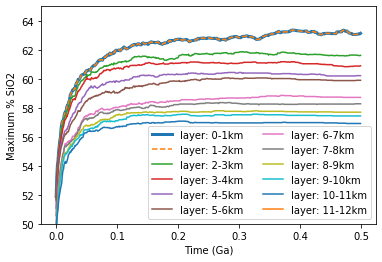

In [14]:

llyr = {i:f"{i}-{i+1}km" for i in range(12)}
for layer in range(12):
    max_sio2_df          = pd.DataFrame(max_sio2_list[layer])
    max_sio2_df['mean']  = max_sio2_df.mean(axis=1)
    if layer==0:
        plt.plot(max_sio2_df.index.values/1000, max_sio2_df['mean'], lw=3,label=f'layer: {llyr[layer]}')
    elif layer==1:
        plt.plot(max_sio2_df.index.values/1000, max_sio2_df['mean'], '--',label=f'layer: {llyr[layer]}')
    else:
        plt.plot(max_sio2_df.index.values/1000, max_sio2_df['mean'], label=f'layer: {llyr[layer]}')
plt.xlabel("Time (Ga)")
plt.ylabel("Maximum % SiO2")
plt.ylim([50,65])
plt.legend(ncol=2)
# plt.savefig('./figs/paper_figs/max_sio2_bound.pdf', dpi=600)
# plt.savefig('./figs/paper_figs/max_sio2_bound.png', dpi=600)
plt.show()
plt.close()

In [15]:
relative_percent_crust_vol = {}

for ensemble in ensembles:
    
    tot_dir = f"sio2_percent_tables/march2022_5/total_relative_crust_{ensemble}.txt"
    with open(tot_dir, "r") as f:
        data = f.read().splitlines()
        
    relative_percent_crust_vol[ensemble] = [np.float(i) for i in data]
    
#     plt.plot(relative_percent_crust_vol)
#     plt.xlabel("Time (Ga)")
#     plt.ylabel("Relative % continental crust volume")
    
# plt.show()
# plt.close()

In [16]:
crust_df

,0,1,2,3,4,5,6,7,8,9,...,48,49,mean,min,max,stdev,e05,e95,c95,c05
0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.001677,0.000000,0.050322,0.010602,0.000178,0.003177,0.004616,-0.001261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.821927,0.905797,1.929012,2.935454,1.79482,2.214171,1.325148,3.187064,1.224503,3.539318,...,2.230945,1.929012,2.079308,0.067096,5.703167,1.399043,1.881453,2.277162,2.467102,1.691513
496,0.788379,0.939345,1.929012,2.969002,1.79482,2.214171,1.325148,3.170290,1.224503,3.539318,...,2.230945,1.895464,2.079643,0.067096,5.736715,1.402585,1.881288,2.277999,2.468420,1.690866
497,0.788379,0.939345,1.962560,2.969002,1.79482,2.180623,1.358696,3.203838,1.190955,3.505770,...,2.230945,1.996108,2.081991,0.067096,5.736715,1.406334,1.883106,2.280877,2.471807,1.692176
498,0.771605,0.939345,1.962560,2.935454,1.79482,2.096753,1.358696,3.119968,1.190955,3.455448,...,2.230945,1.996108,2.073269,0.083870,5.703167,1.400970,1.875142,2.271396,2.461598,1.684940


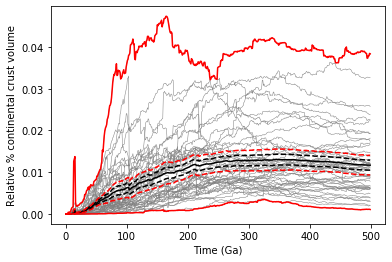

In [17]:
crust_df = pd.DataFrame(relative_percent_crust_vol)
for ensemble in ensembles:
    plt.plot(np.array(relative_percent_crust_vol[ensemble]), c="grey", lw=0.5)
    plt.xlabel("Time (Ga)")
    plt.ylabel("Relative % continental crust volume")
    
crust_df['mean'] = crust_df.mean(axis=1)
crust_df['min'] = crust_df.min(axis=1)
crust_df['max'] = crust_df.max(axis=1)
crust_df['stdev'] = crust_df.std(axis=1)
standard_error = crust_df['stdev']/np.sqrt(len(ensembles))
crust_df['e05'] = crust_df['mean'] - standard_error
crust_df['e95'] = crust_df['mean'] + standard_error
crust_df['c95'] = crust_df['mean'] + standard_error * 1.96
crust_df['c05'] = crust_df['mean'] - standard_error * 1.96

plt.plot(crust_df['mean'], c='k', label='mean')
plt.plot(crust_df['e05'], '--', c='k', label='standard error')
plt.plot(crust_df['e95'], '--', c='k')
plt.plot(crust_df['c05'].clip(lower=0), '--', c='r', label='05/95% confidence')
plt.plot(crust_df['c95'], '--', c='r')
plt.plot(crust_df['min'].clip(lower=0), c='r', label='min/max')
plt.plot(crust_df['max'], c='r')
plt.xlabel("Time (Ga)")
plt.ylabel("Relative % continental crust volume")
    
    
plt.show()
plt.close()